<!DOCTYPE html>
<head>
    <meta charset="utf-8">
    <link rel="stylesheet" href="styles.css">
    <link href='https://fonts.googleapis.com/css?family=Merriweather' rel='stylesheet'>
    <div style="background-color: #3D0069; color: white ; font-family: 'Merriweather'; font-weight: bold; text-align: center; padding: 40px; font-size: 16px;">
    <h1>Interrogation of the Parch  & Posey (P & P) Database to Improve Sales Performance</h1>
        by
    
    Buhari Shehu (The Datavestigator)
     

</head>


<img src="erd.png" width=700 height=200 />

<div style="background-color: #F5E8DA; padding: 10px;font-family: 'Merriweather'; font-size: 16px;">
<h2>Table of Contents</h2>
<ol>
<li><a href="#intro">Executive Summary</a></li>    
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Methodology</a></li>
<li><a href="#eda">Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
<li><a href="#model">Recommendations</a></li>
<li><a href="#references">References</a></li>
</ol>
</div>

<link href='https://fonts.googleapis.com/css?family=Merriweather' rel='stylesheet'>
<h2 style="background-color: #F5E8DA; color: #50006C; font-family: 'Merriweather'; font-weight: bold; font-size: 20px; text-align: center; padding: 10px 0;">
  1. Executive Summary
</h2>


<link href='https://fonts.googleapis.com/css?family=Merriweather' rel='stylesheet'>
<h2 style="background-color: #F5E8DA; color: #50006C; font-family: 'Merriweather'; font-weight: bold; font-size: 20px; text-align: center; padding: 10px 0;">
  2. Introduction
</h2>


<link href='https://fonts.googleapis.com/css?family=Merriweather' rel='stylesheet'>
<h2 style="background-color: #F5E8DA; color: #50006C; font-family: 'Merriweather'; font-weight: bold; font-size: 20px; text-align: center; padding: 10px 0;">
  3. Methodology
</h2>


<link href='https://fonts.googleapis.com/css?family=Merriweather' rel='stylesheet'>
<h2 style="background-color: #F5E8DA; color: #50006C; font-family: 'Merriweather'; font-weight: bold; font-size: 20px; text-align: center; padding: 10px 0;">
  4. Analysis
</h2>


### 4.1 Import dependencies and load the database

To ensure the successful execution of this project, it is crucial to have the following listed packages installed:
- `numpy`
- `pandas`
- `matplotlib`
- `seaborn`
- `sqlalchemy`
- `ipython-sql`
- `pymysql`

In [298]:
# Import data analysis toolkits
import pandas as pd
import numpy as np

# Import visualization libraries
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
# Override matplotlib 
sns.set()

In [7]:
# Load Magic commands
%load_ext sql

# Load SQLite database
%sql sqlite:///pandp.db

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


***Which tables are in the database?***

In [13]:
%%sql
SELECT name tables
FROM sqlite_master 
WHERE type IN ('table','view') AND name NOT LIKE 'sqlite_%' 
ORDER BY 1;

 * sqlite:///pandp.db
Done.


tables
accounts
orders
region
sales_reps
web_events


The database includes tables for **`accounts, orders, region`**, sales representatives (**`sales_reps`**), and web events (**`web_events`**).

***When were the earliest and latest orders placed?***

In [15]:
%%sql
SELECT MIN(STRFTIME('%Y %m %d', occurred_at)) 'earliest order date', MAX(STRFTIME('%Y %m %d', occurred_at)) 'latest order date'
FROM orders;

 * sqlite:///pandp.db
Done.


earliest order date,latest order date
2013 12 04,2017 01 02


The earliest recorded order was placed in **`December 4th, 2013`** and the most recent order was placed on **`January 2nd, 2017`**. As a result, these two years will be excluded from some analyses due to the lack of sufficient data.

### 4.2 Sales representatives

***What is the number of sales representatives at P&P?***

In [336]:
%%sql
SELECT COUNT(*) 'number of sales representatives'
FROM sales_reps;

 * sqlite:///pandp.db
Done.


number of sales representatives
50


There are **`50`** sales representatives at **P&P**.

***Which sales representatives are the top and bottom five performers?***

- **Top perfomers**

In [24]:
%%sql
SELECT s.name sales_rep, ROUND(SUM(o.total_amt_usd), 2) total_sales
FROM sales_reps s
JOIN accounts a
ON s.id = a.sales_rep_id
JOIN orders o
ON a.id = o.account_id
GROUP BY 1
ORDER BY 2 DESC
LIMIT 5;

 * sqlite:///pandp.db
Done.


sales_rep,total_sales
Earlie Schleusner,1098137.72
Tia Amato,1010690.6
Vernita Plump,934212.93
Georgianna Chisholm,886244.12
Arica Stoltzfus,810353.34


The top sales representatives are **`Earlie Schleusner, Tia Amato, Vernita Plump, Georgianna Chisholm, Arica Stoltzfus`**. Each of them recorded more than **`$800,000`** in sales.

- **Low performers**

In [25]:
%%sql
SELECT s.name sales_rep, ROUND(SUM(o.total_amt_usd), 2) total_sales
FROM sales_reps s
JOIN accounts a
ON s.id = a.sales_rep_id
JOIN orders o
ON a.id = o.account_id
GROUP BY 1
ORDER BY 2
LIMIT 5;

 * sqlite:///pandp.db
Done.


sales_rep,total_sales
Nakesha Renn,49361.11
Julie Starr,89097.65
Elba Felder,114976.59
Kathleen Lalonde,116307.79
Akilah Drinkard,136613.99


The low performers are **Nakesha Renn, Julie Starr, Elba Felder, Kathleen Lalonde, Akilah Drinkard** each of them recorded less than **$150,000** in sales. This is more than **500% difference** from the top perfomers.

### What is the performance trends/behaviour of the top performing sales reps??

In [77]:
%%sql
SELECT s.name sales_rep, STRFTIME('%Y', o.occurred_at) year, ROUND(SUM(o.total_amt_usd), 2) total_sales
FROM sales_reps s
JOIN accounts a
ON s.id = a.sales_rep_id
JOIN orders o
ON a.id = o.account_id
WHERE s.name IN ('Earlie Schleusner', 'Tia Amato', 'Vernita Plump', 'Georgianna Chisholm', 'Arica Stoltzfus')
GROUP BY 1, 2
ORDER BY 1;

 * sqlite:///pandp.db
Done.


sales_rep,year,total_sales
Arica Stoltzfus,2013,19596.7
Arica Stoltzfus,2014,178758.0
Arica Stoltzfus,2015,312236.42
Arica Stoltzfus,2016,291377.61
Arica Stoltzfus,2017,8384.61
Earlie Schleusner,2013,33182.64
Earlie Schleusner,2014,253434.98
Earlie Schleusner,2015,241763.05
Earlie Schleusner,2016,560717.22
Earlie Schleusner,2017,9039.83


In [87]:
# Create high sales reps df
high_sales_reps_query = %sql SELECT s.name sales_rep, STRFTIME('%Y', o.occurred_at) year, ROUND(SUM(o.total_amt_usd), 2) total_sales FROM sales_reps s JOIN accounts a ON s.id = a.sales_rep_id JOIN orders o ON a.id = o.account_id WHERE s.name IN ('Earlie Schleusner', 'Tia Amato', 'Vernita Plump', 'Georgianna Chisholm', 'Arica Stoltzfus') GROUP BY 1, 2 ORDER BY 2
high_sales_reps_df = high_sales_reps_query.DataFrame()

 * sqlite:///pandp.db
Done.


In [255]:
def plot_bar(x, y, hue, df):
    """
    Create a bar plot using Seaborn.
    
    Parameters:
    x (str): The column to use for the x-axis.
    y (str): The column to use for the y-axis.
    hue (str): The column to use for color encoding.
    df (pandas.DataFrame): The dataframe to use for the plot.
    
    Returns:
    None
    """
    plt.figure(figsize=(10, 6)) 
    sns.barplot(x=x, y=y, hue=hue, data=df)
    plt.show()


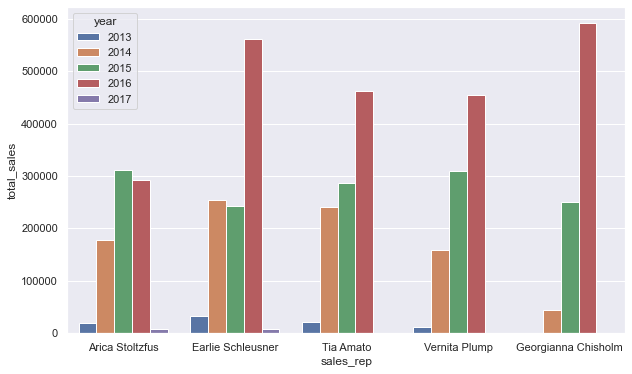

In [256]:
plot_bar(x='sales_rep', y='total_sales', hue='year', df=high_sales_reps_df)


The top performers are in close competition/contention with one another and they are improving annually.

### Why Nakesha Renn and co are having low cummulative sales?

In [31]:
%%sql
SELECT s.name sales_rep, STRFTIME('%Y', o.occurred_at) year, ROUND(SUM(o.total_amt_usd), 2) total_sales
FROM sales_reps s
JOIN accounts a
ON s.id = a.sales_rep_id
JOIN orders o
ON a.id = o.account_id
WHERE s.name IN ('Nakesha Renn', 'Julie Starr', 'Elba Felder', 'Kathleen Lalonde', 'Akilah Drinkard')
GROUP BY 1, 2
ORDER BY 1;

 * sqlite:///pandp.db
Done.


sales_rep,year,total_sales
Akilah Drinkard,2014,41117.38
Akilah Drinkard,2015,38109.41
Akilah Drinkard,2016,57387.2
Elba Felder,2013,1228.72
Elba Felder,2014,22893.08
Elba Felder,2015,38088.2
Elba Felder,2016,51730.02
Elba Felder,2017,1036.57
Julie Starr,2013,738.54
Julie Starr,2014,22979.77


In [74]:
# Create low sales reps df
low_sales_reps_query = %sql SELECT s.name sales_rep, STRFTIME('%Y', o.occurred_at) year, ROUND(SUM(o.total_amt_usd), 2) total_sales FROM sales_reps s JOIN accounts a ON s.id = a.sales_rep_id JOIN orders o ON a.id = o.account_id WHERE s.name IN ('Nakesha Renn', 'Julie Starr', 'Elba Felder', 'Kathleen Lalonde', 'Akilah Drinkard') GROUP BY 1, 2 ORDER BY 2 
low_sales_reps_df = low_sales_reps_query.DataFrame()

 * sqlite:///pandp.db
Done.


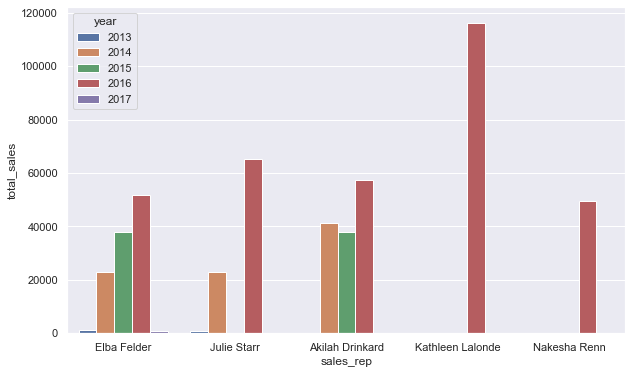

In [257]:
plot_bar(x='sales_rep', y='total_sales', hue='year', df=low_sales_reps_df)

- Kathleen and Nakesha only have sales in 2016 which is probably the year they join the company. Thus Kathleen may not be in the low perfomers category. Nakesha may perform better in subsequent years as she gain experience.
- Elba has stunted growth
- Julie has no sale in 2015 probably was on leave.
- Akilah has irregular performance.

<div style="border: 5px solid #6f00ff;
    border-radius: 20px; text-align: center; font-size: 20px; font-family: 'Merriweather'; padding: 16px 0; background-color: #F5E8DA">
  <b>What are the account names and the sales representative for the top three accounts above?</b>
</div>

In [57]:
%%sql
SELECT a.name account_name, s.name sales_rep,  o.total_amt_usd
FROM orders o
JOIN accounts a
ON o.account_id = a.id
JOIN sales_reps s
ON a.sales_rep_id = s.id
WHERE total_amt_usd > 100000
ORDER BY 3 DESC;

 * sqlite:///pandp.db
Done.


account_name,sales_rep,total_amt_usd
Pacific Life,Dawna Agnew,232207.07
Core-Mark Holding,Maryanna Fiorentino,112875.18
EOG Resources,Arica Stoltzfus,107533.55


### Customers

<div style="border: 5px solid #3D0069;
    border-radius: 10px; text-align: center; font-size: 20px; font-family: 'Merriweather'; padding: 10px; background-color: #F5E8DA">
  <b>Customers?</b>
</div>

**How many customers?**

In [93]:
%%sql
SELECT COUNT(*) number_of_customers
FROM accounts;

 * sqlite:///pandp.db
Done.


number_of_customers
351


P&P has 351 customers

**Top 5 and lowest 5 customers**

In [98]:
%%sql
SELECT a.name, ROUND(SUM(o.total_amt_usd), 2) total_purchase
FROM accounts a
JOIN orders o
ON a.id = o.account_id
GROUP BY 1
ORDER BY 2 DESC
LIMIT 5;

 * sqlite:///pandp.db
Done.


name,total_purchase
EOG Resources,382873.3
Mosaic,345618.59
IBM,326819.48
General Dynamics,300694.79
Republic Services,293861.14


P&P top customers are **EOG Resources, Mosaic, IBM, General Dynamics, Republic Services** with a range of spending close to **$300,000 - $400,000.**

In [101]:
%%sql
WITH cte AS (SELECT a.name, ROUND(SUM(o.total_amt_usd), 2) total_purchase
FROM accounts a
JOIN orders o
ON a.id = o.account_id
GROUP BY 1
ORDER BY 2
LIMIT 5)

SELECT *
FROM cte
ORDER BY 2 DESC;

 * sqlite:///pandp.db
Done.


name,total_purchase
Bed Bath & Beyond,1069.64
Deere,1036.57
Level 3 Communications,881.73
Delta Air Lines,859.64
Nike,390.25


**Habits of top and lowest customers**

In [259]:
%%sql
SELECT  a.name, STRFTIME('%Y',  o.occurred_at) year,  ROUND(SUM(o.total_amt_usd),2) annual_purchase
FROM accounts a 
JOIN orders o
ON o.account_id = a.id
WHERE a.name IN ('G Resources', 'Mosaic', 'IBM', 'General Dynamics',  'Republic Services')
GROUP BY 1, 2;

 * sqlite:///pandp.db
Done.


name,year,annual_purchase
General Dynamics,2013,10166.07
General Dynamics,2014,88383.04
General Dynamics,2015,103768.09
General Dynamics,2016,98377.59
IBM,2013,9580.87
IBM,2014,85418.97
IBM,2015,146537.01
IBM,2016,85282.63
Mosaic,2013,8348.08
Mosaic,2014,78933.56


In [260]:
top_customers_qry = %sql SELECT  a.name, STRFTIME('%Y',  o.occurred_at) year, ROUND(SUM(o.total_amt_usd),2) annual_purchase FROM accounts a JOIN orders o ON o.account_id = a.id WHERE a.name IN ('G Resources', 'Mosaic', 'IBM', 'General Dynamics',  'Republic Services') GROUP BY 1, 2;
top_customers_df = top_customers_qry.DataFrame()


 * sqlite:///pandp.db
Done.


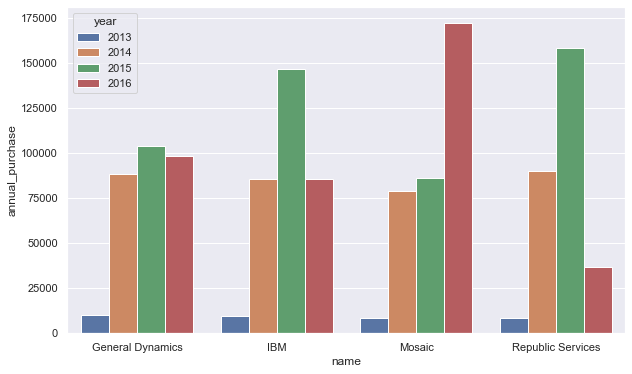

In [261]:
plot_bar(x='name', y='annual_purchase', hue='year', df=top_customers_df)

- Although 2016 is the best for P&P their top 5 customers made thei largest purchase in 2015 with the exception of mosiac. There is a need to dig into the reason for the decline . 

In [262]:
%%sql
SELECT  a.name, STRFTIME('%Y',  o.occurred_at) year,  ROUND(SUM(o.total_amt_usd),2) annual_purchase
FROM accounts a 
JOIN orders o
ON o.account_id = a.id
WHERE a.name IN ('Bed Bath & Beyond', 'Deere', 'Level 3 Communications', 'Delta Air Lines', 'Nike')
GROUP BY 1, 2;

 * sqlite:///pandp.db
Done.


name,year,annual_purchase
Bed Bath & Beyond,2013,1069.64
Deere,2017,1036.57
Delta Air Lines,2016,859.64
Level 3 Communications,2015,881.73
Nike,2016,390.25


In [264]:
low_customers_qry = %sql SELECT  a.name, STRFTIME('%Y',  o.occurred_at) year, ROUND(SUM(o.total_amt_usd),2) annual_purchase FROM accounts a JOIN orders o ON o.account_id = a.id WHERE a.name IN ('Bed Bath & Beyond', 'Deere', 'Level 3 Communications', 'Delta Air Lines', 'Nike') GROUP BY 1, 2;
low_customers_df = top_customers_qry.DataFrame()

 * sqlite:///pandp.db
Done.


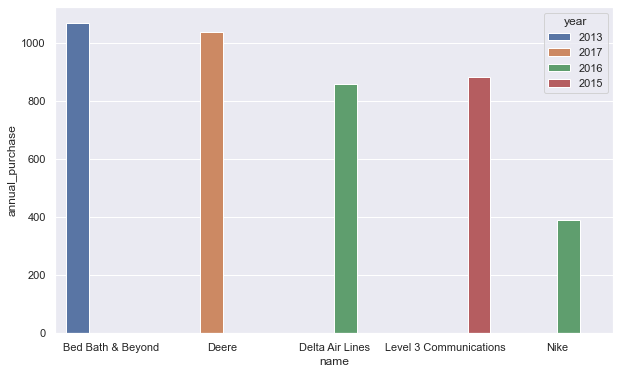

In [265]:
plot_bar(x='name', y='annual_purchase', hue='year', df=top_customers_df)

- All low performers purchased from the company fro the period of one year
- **Bed Bath & Beyond** and **Level 3 Communications** only transacted with the company in 2013 and 2015 respectively. They have churned.
- Delta Air Lines and Nike only transacted in 2016 while Deere only transact in 2017. They are new customers.

**New Customers**

In [109]:
%%sql
SELECT  STRFTIME('%Y', occurred_at) year,  COUNT(DISTINCT account_id) number_of_customers
FROM orders
GROUP BY 1;

 * sqlite:///pandp.db
Done.


year,number_of_customers
2013,61
2014,80
2015,134
2016,317
2017,14


In [139]:


%%sql
WITH cte AS (SELECT DISTINCT account_id FROM orders WHERE STRFTIME('%Y', occurred_at) != '2013')

SELECT DISTINCT account_id 
FROM orders o
JOIN cte
ON o.account_id = cte.account_id
WHERE STRFTIME('%Y', o.occurred_at) = '2013' AND (account_id NOT IN cte.account_id)

 * sqlite:///pandp.db
(sqlite3.OperationalError) no such table: cte.account_id
[SQL: WITH cte AS (SELECT DISTINCT account_id FROM orders WHERE STRFTIME('%Y', occurred_at) != '2013')

SELECT DISTINCT account_id 
FROM orders o
JOIN cte
ON o.account_id = cte.account_id
WHERE STRFTIME('%Y', o.occurred_at) = '2013' AND (account_id NOT IN cte.account_id)]
(Background on this error at: https://sqlalche.me/e/14/e3q8)


In [141]:
%%sql

WITH cte AS (
    SELECT DISTINCT account_id FROM orders WHERE STRFTIME('%Y', occurred_at) != '2013'
)
SELECT *
FROM cte
JOIN orders o
ON cte.account_id = o.account_id
WHERE STRFTIME('%Y', o.occurred_at) = '2013' AND (account_id NOT IN cte.account_id);


 * sqlite:///pandp.db
(sqlite3.OperationalError) no such table: cte.account_id
[SQL: WITH cte AS (
    SELECT DISTINCT account_id FROM orders WHERE STRFTIME('%Y', occurred_at) != '2013'
)
SELECT *
FROM cte
JOIN orders o
ON cte.account_id = o.account_id
WHERE STRFTIME('%Y', o.occurred_at) = '2013' AND (account_id NOT IN cte.account_id);]
(Background on this error at: https://sqlalche.me/e/14/e3q8)


In [119]:
%%sql
SELECT COUNT(DISTINCT account_id)
FROM orders 
WHERE STRFTIME('%Y', occurred_at) != '2013'

 * sqlite:///pandp.db
Done.


COUNT(DISTINCT account_id)
349


**Segementation**

In [267]:
%%sql
SELECT account_id, ROUND(SUM(total_amt_usd), 2) total_purchase
FROM orders
GROUP BY 1
LIMIT 5;

 * sqlite:///pandp.db
Done.


account_id,total_purchase
1001,124014.87
1011,2734.59
1021,20767.15
1031,7474.32
1041,15184.46


In [268]:
segement_qry = %sql SELECT account_id, ROUND(SUM(total_amt_usd), 2) total_purchase FROM orders GROUP BY 1
segment_df = segement_qry.DataFrame()

 * sqlite:///pandp.db
Done.


In [269]:
segment_df.describe(percentiles=[0.2, 0.4, 0.6, 0.8, 0.9])

,account_id,total_purchase
count,350.000000,350.000000
mean,2753.914286,66118.605229
std,1014.672626,71299.263574
min,1001.000000,390.250000
20%,1699.000000,11450.198000
40%,2407.000000,27364.832000
50%,2756.000000,38337.055000
60%,3105.000000,54832.256000
80%,3803.000000,118938.526000
90%,4152.000000,156676.340000


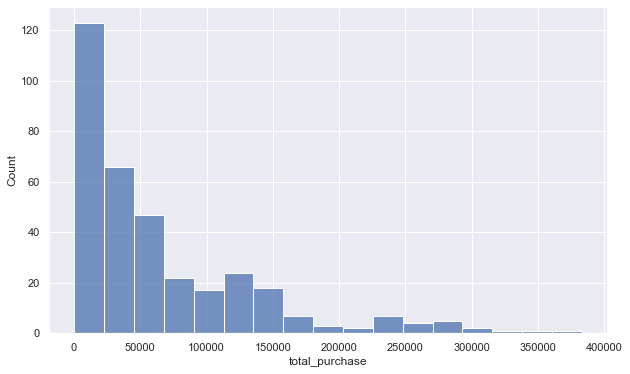

In [270]:
# Create the plot
plt.figure(figsize=(10, 6)) 

# Create the plot
sns.histplot(data=segment_df, x='total_purchase')

# Set the x-axis scale to log
#plt.gca().set(xscale='log')

# Show the plot
plt.show()

In [271]:
%%sql
WITH cte1 AS (
    SELECT account_id, 
           ROUND(SUM(total_amt_usd), 2) total_purchase
    FROM orders
    GROUP BY 1
),
cte2 AS (
    SELECT account_id, 
           total_purchase,
           CASE 
               WHEN total_purchase > 150000 THEN 'Platinum'
               WHEN total_purchase > 100000 AND total_purchase <= 150000 THEN 'Gold'
               WHEN total_purchase > 50000 AND total_purchase <= 100000 THEN 'Silver'
               ELSE 'Bronze' END AS segment
    FROM cte1
)
SELECT segment, COUNT(segment) count
FROM cte2
GROUP BY 1
ORDER BY 2 DESC;


 * sqlite:///pandp.db
Done.


segment,count
Bronze,203
Silver,65
Gold,43
Platinum,39


In [275]:
# Collect segmentation query output in a dictionary
segements = {'segment': ['Bronze', 'Silver', 'Gold', 'Platinum'], 
             'count': [203, 65, 43, 39]}
# Create the DataFrame 
segements_df = pd.DataFrame(segements)
segements_df

,segment,count
0,Bronze,203
1,Silver,65
2,Gold,43
3,Platinum,39


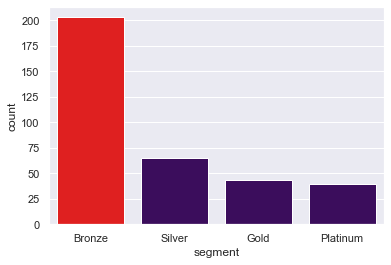

In [276]:
colour = '#3D0069'
colours = [colour for i in range(len(channel_df)-1)]
palette = ['red']
palette.extend(colours)

ax = sns.barplot(x='segment', y='count', data=segements_df, palette=palette)

**Has any Platinum customer churn?**

In [ ]:
%%sql
WITH cte AS (SELECT account_id , ROUND(SUM(total_amt_usd), 2) total
FROM orders
GROUP BY 1)

SELECT *
FROM cte
JOIN orders o
ON o.account_id = cte.account_id
WHERE cte.total > 150000

In [290]:
STRFTIME('%Y', occurred_at) year

SyntaxError: invalid syntax (1891646072.py, line 1)

### Channels

How many channels?

In [295]:
%%sql
SELECT COUNT(DISTINCT channel) 'number of channels'
FROM web_events

 * sqlite:///pandp.db
Done.


number of channels
6


**P&P** has 6 channels.

Most profitable channel

In [179]:
%%sql
SELECT w.channel, ROUND(SUM(o.total_amt_usd/1e6), 2) total_sales_million_usd
FROM orders o
JOIN accounts a
ON o.account_id = a.id
JOIN web_events w
ON w.account_id = a.id

GROUP BY 1
ORDER BY 2 DESC;

 * sqlite:///pandp.db
Done.


channel,total_sales_million_usd
direct,639.7
facebook,103.03
organic,102.05
adwords,97.78
twitter,50.67
banner,48.08


In [180]:
# create revenue by channel
channel = %sql SELECT w.channel, ROUND(SUM(o.total_amt_usd/1e6), 2) total_sales_million_usd FROM orders o JOIN accounts a ON o.account_id = a.id JOIN web_events w ON w.account_id = a.id WHERE o.occurred_at GROUP BY 1 ORDER BY 2 DESC;
channel_df = channel.DataFrame()

 * sqlite:///pandp.db
Done.


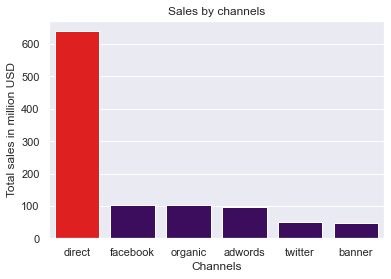

In [182]:
# Create a bar plot with the 'channel' column on the x-axis and the 'total_sales_million_usd' column on the y-axis
# Define colour palette
colour = '#3D0069'
colours = [colour for i in range(len(channel_df)-1)]
palette = ['red']
palette.extend(colours)

ax = sns.barplot(x='channel', y='total_sales_million_usd', data=channel_df, palette=palette)

# Set the x-axis label to 'Channels'
ax.set_xlabel('Channels')

# Set the y-axis label to 'Total sales in million USD'
ax.set_ylabel('Total sales in million USD')

# Set the title to 'Revenue by channel'
ax.set_title('Sales by channels');


The amount of sales recorded via the direct channel is more than what all the remaining channels made combined.

**Regions**

How many regions?

In [304]:
%%sql
SELECT COUNT(DISTINCT name) 'number_of_regions'
FROM region

 * sqlite:///pandp.db
Done.


number_of_regions
4


**P&P** operates in four regions.

Proportional contributions by regions

In [187]:
%%sql
SELECT r.name, ROUND(SUM(o.total_amt_usd), 2) total_purchase
FROM region r
JOIN sales_reps s
ON r.id = s.region_id
JOIN accounts a
ON s.id = a.sales_rep_id
JOIN orders o
ON a.id = o.account_id
GROUP BY 1
ORDER BY 2 DESC

 * sqlite:///pandp.db
Done.


name,total_purchase
Northeast,7744405.36
Southeast,6458497.0
West,5925122.96
Midwest,3013486.51


In [305]:
regions = {'name': ['Northeast', 'Southeast', 'West', 'Midwest'], 
           'total_purchase': [7744405.36, 6458497.0, 5925122.96, 3013486.51]}
regions_df = pd.DataFrame(regions)
regions_df

,name,total_purchase
0,Northeast,7744405.36
1,Southeast,6458497.00
2,West,5925122.96
3,Midwest,3013486.51


**Graph**

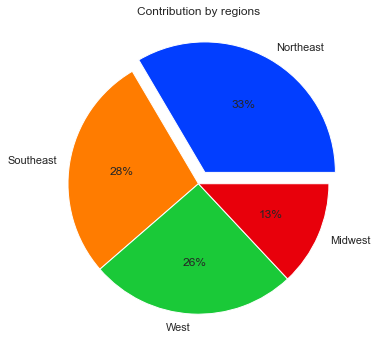

In [317]:
# Create the plot
plt.figure(figsize=(12, 6)) 

labels = regions_df['name']
values = regions_df['total_purchase']

# declaring exploding pie
explode = [0.1, 0, 0, 0] 
# define Seaborn color palette to use
palette_color = sns.color_palette('bright')

# Create the pie chart
plt.pie(x=values, labels=labels, colors=palette_color, explode = explode, autopct='%.0f%%')

# Add a title
plt.title('Contribution by regions')

# Show the plot
plt.show()

### Products

<div style="border: 5px solid #3D0069;
    border-radius: 10px; text-align: center; font-size: 20px; font-family: 'Merriweather'; padding: 10px; background-color: #F5E8DA">
  <b>Products?</b>
</div>

Total sales for all products

In [318]:
%%sql
SELECT ROUND(SUM(standard_amt_usd)/1e6, 2) total_standard_usd, 
ROUND(SUM(gloss_amt_usd)/1e6, 2) total_gloss_usd, 
ROUND(SUM(poster_amt_usd)/1e6, 2) total_poster_usd
FROM orders

 * sqlite:///pandp.db
Done.


total_standard_usd,total_gloss_usd,total_poster_usd
9.67,7.59,5.88


- Standard paper 9.67 million USD
- Gloss paper 7.59 million USD
- Poster paper 5.88 million USD

***Proportional Contribution***

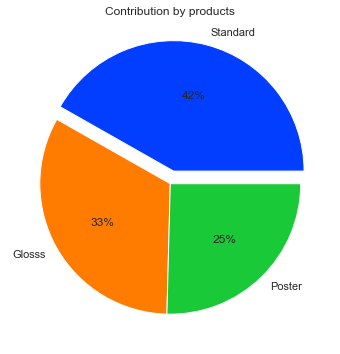

In [328]:
# Create the plot
plt.figure(figsize=(12, 6)) 

labels = ['Standard', 'Glosss', 'Poster']
values = [9.67, 7.59, 5.88]

# declaring exploding pie
explode = [0.1, 0, 0] 
# define Seaborn color palette to use
palette_color = sns.color_palette('bright')

# Create the pie chart
plt.pie(x=values, labels=labels, colors=palette_color, explode = explode, autopct='%.0f%%')

# Add a title
plt.title('Contribution by products')

# Show the plot
plt.show()

- **Monthly average number of orders year 2016**

In [206]:
%%sql
WITH cte AS (SELECT STRFTIME('%m', occurred_at) month, 
        SUM(standard_qty) total_standard_qty,
        SUM(gloss_qty) total_gloss_qty,
        SUM(poster_qty) total_poster_qty
FROM orders
WHERE occurred_at BETWEEN '2016-01-01' AND '2017-01-01'
GROUP BY 1)

SELECT ROUND(AVG(total_standard_qty)) avg_standard_qty,
        ROUND(AVG(total_gloss_qty)) avg_gloss_qty,
        ROUND(AVG(total_poster_qty)) avg_poster_qty
FROM cte

 * sqlite:///pandp.db
Done.


avg_standard_qty,avg_gloss_qty,avg_poster_qty
89563.0,46151.0,34420.0


The average orders for each paper is given in the following table

| Paper Type| Count | 
|----------|----------|
| Standard  | 89563    |
| Gloss  | 46151     |
|Poster| 34420   |


The average order of standard paper in 2016 is 89 thousand, gloss is 46 thousand and poster is 34 thousand.

- **Monthly Max and min year 2016**

In [205]:
%%sql
WITH cte AS (SELECT STRFTIME('%m', occurred_at) month, 
        SUM(standard_qty) total_standard_qty,
        SUM(gloss_qty) total_gloss_qty,
        SUM(poster_qty) total_poster_qty
FROM orders
WHERE occurred_at BETWEEN '2016-01-01' AND '2017-01-01'
GROUP BY 1)

SELECT MAX(total_standard_qty) max_standard_qty,
        MAX(total_gloss_qty) max_gloss_qty,
        MAX(total_poster_qty) max_poster_qty
FROM cte

 * sqlite:///pandp.db
Done.


max_standard_qty,max_gloss_qty,max_poster_qty
123997,67667,79398


Standard paper has a maximum monthly order of 123 thousand, gloss has a maximum order of 67 thousand and poster has a maximum order of 79 thousand in 2016.

In [207]:
%%sql
WITH cte AS (SELECT STRFTIME('%m', occurred_at) month, 
        SUM(standard_qty) total_standard_qty,
        SUM(gloss_qty) total_gloss_qty,
        SUM(poster_qty) total_poster_qty
FROM orders
WHERE occurred_at BETWEEN '2016-01-01' AND '2017-01-01'
GROUP BY 1)

SELECT MIN(total_standard_qty) min_standard_qty,
        MIN(total_gloss_qty) min_gloss_qty,
        MIN(total_poster_qty) min_poster_qty
FROM cte

 * sqlite:///pandp.db
Done.


min_standard_qty,min_gloss_qty,min_poster_qty
56022,27765,16358


Standard paper has a minimum monthly order of 56 thousand, gloss has a minimum order of 27 thousand and poster has a minimum order of 16 thousand in 2016.

<div style="border: 5px solid #6f00ff;
    border-radius: 20px; text-align: center; font-size: 20px; font-family: 'Merriweather'; padding: 16px 0; background-color: #F5E8DA">
  <b>Which orders contain only standard paper with a quantity greater than 1000?<b>
</div>

In [37]:
%%sql
SELECT *
FROM orders
WHERE standard_qty > 1000 AND poster_qty = 0 AND gloss_qty = 0;

 * sqlite:///pandp.db
Done.


id,account_id,occurred_at,standard_qty,gloss_qty,poster_qty,total,standard_amt_usd,gloss_amt_usd,poster_amt_usd,total_amt_usd
2613,2951,2016-08-15 00:06:12,1171,0,0,1171,5843.29,0,0,5843.29
3260,3491,2014-08-29 22:43:00,1552,0,0,1552,7744.48,0,0,7744.48


**GROWTH**

- Running totals
- That comparison chart
- Annual growth rates comparison

The preschool's enrollment numbers for the past four years are:

350 in 2016
390 in 2017
402 in 2018
489 in 2019
You can use the average growth rate over time calculation method to find the average annual growth rate for the preschool. In this example, the present value is 489, the past value is 328 and the number of years is 4:

Growth rate after 2016: (390 - 350) / 350 x 100 = 11.43%
Growth rate after 2017: (402 - 390) / 390 x 100 = 3.08%
Growth rate after 2018: (489 - 402) / 402 x 100 = 21.64%
Average growth rate over time = (11.43% + 3.08% + 21.64%) / 3 = 12.05% per year

In [ ]:
100*(current - lag)/lag

In [241]:
%%sql
WITH cte AS (SELECT STRFTIME('%Y', occurred_at) year, ROUND(SUM(total_amt_usd),2) annual_amt_usd
FROM orders
GROUP BY 1
ORDER BY 1)

SELECT  year, 
        annual_amt_usd, 
        LAG(annual_amt_usd) OVER (ORDER BY year) AS lag,
        ROUND(100*(annual_amt_usd - LAG(annual_amt_usd) OVER (ORDER BY year))/LAG(annual_amt_usd) OVER (ORDER BY year), 2) AS growth_rate
FROM cte
WHERE year NOT IN ('2013', '2017')

 * sqlite:///pandp.db
Done.


year,annual_amt_usd,lag,growth_rate
2014,4069106.54,None,None
2015,5752004.94,4069106.54,41.36
2016,12864917.92,5752004.94,123.66


<div style="border: 5px solid #6f00ff;
    border-radius: 20px; text-align: center; font-size: 20px; font-family: 'Merriweather'; padding: 16px 0; background-color: #F5E8DA">
  <b>Comparing 2016 to 2015, how did sales fare?</b>
</div>

In [247]:
%%sql
SELECT strftime('%Y %m', occurred_at) years, strftime('%m', occurred_at) months, ROUND(SUM(total_amt_usd), 2) total_sales
FROM orders
WHERE occurred_at LIKE '2015%' OR occurred_at LIKE '2016%'
GROUP BY 1

 * sqlite:///pandp.db
Done.


years,months,total_sales
2015 01,01,347804.3
2015 02,02,333688.01
2015 03,03,519403.4
2015 04,04,451753.57
2015 05,05,390830.84
2015 06,06,420906.13
2015 07,07,461895.49
2015 08,08,463754.33
2015 09,09,510848.57
2015 10,10,554190.81


In [248]:
total_sales_qry = %sql SELECT strftime('%Y %m', occurred_at) years, strftime('%m', occurred_at) months, ROUND(SUM(total_amt_usd), 2) average_sales FROM orders WHERE occurred_at LIKE '2015%' OR occurred_at LIKE '2016%' GROUP BY 1
total_sales_df = total_sales_qry.DataFrame()

 * sqlite:///pandp.db
Done.


<AxesSubplot:xlabel='months', ylabel='month_over_month_change'>

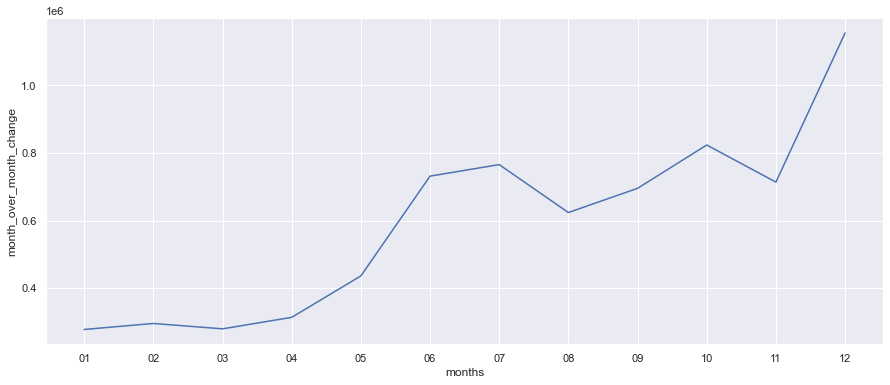

In [253]:
total_sales_df['month_over_month_change'] = total_sales_df['average_sales'] - total_sales_df['average_sales'].shift(12)
# Set the figure size to 10 inches wide and 6 inches tall

plt.figure(figsize=(15, 6))
# Create a line plot with the year on the x-axis and the YoY change on the y-axis
sns.lineplot(x='months', y='month_over_month_change', data=total_sales_df)

- high variability
- overall 2015 was better
- seems no seasonality in the dataset
- high volatility = high variability?

In [ ]:
%%sql
SELECT
FROM

Sales persons
- How many
- Top 5 and Lowest 5?

Cutomers
- Count
- Top 5 and lowest 5
- Habits of top and low
- New customers
- Attrition
- Customer segmentation based on their purchase: CASE, Know the distribution of the , Plot their distribution after segmenting 




Channels
- Distribution 
- Trend
- Regions
- Top regions

Products
- Top product of all time
- Trends for three years
- MAX orders for all
- MIN orders 
- Average orders
- Distribution of orders 




Growth
- Ytd
- Running totals
- That comparison chart
- Lead, lag?.
- Annual growth rates comparison
- Trends YOY
Compare monthly and annual number of sales




<div style="border: 5px solid #3D0069;
    border-radius: 10px; text-align: center; font-size: 20px; font-family: 'Merriweather'; padding: 10px; background-color: #F5E8DA">
  <b>When were the earliest and latest orders placed?</b>
</div>

In [15]:
%%sql
SELECT MIN(STRFTIME('%Y %m %d', occurred_at)) 'earliest order date', MAX(STRFTIME('%Y %m %d', occurred_at)) 'latest order date'
FROM orders;

 * sqlite:///pandp.db
Done.


earliest order date,latest order date
2013 12 04,2017 01 02


The earliest recorded order was placed in December 2013 and the most recent order was placed on January 2nd, 2017. As a result, these two years will be excluded from some analyses due to the lack of sufficient data.

<div style="border: 5px solid #6f00ff;
    border-radius: 20px; text-align: center; font-size: 20px; font-family: 'Merriweather'; padding: 16px 0; background-color: #F5E8DA">
  <b>In which accounts did the top five purchases of all time occur?<b>
</div>

In [18]:
%%sql
SELECT account_id, total_amt_usd
FROM orders
ORDER BY total_amt_usd DESC
LIMIT 5;

 * sqlite:///pandp.db
Done.


account_id,total_amt_usd
4251,232207.07
4161,112875.18
4211,107533.55
2861,95005.82
4101,93547.84


<link href='https://fonts.googleapis.com/css?family=Merriweather' rel='stylesheet'>
<h2 style="background-color: #F5E8DA; color: #50006C; font-family: 'Merriweather'; font-weight: bold; font-size: 20px; text-align: center; padding: 10px 0;">
  5. Conclusions
</h2>


<link href='https://fonts.googleapis.com/css?family=Merriweather' rel='stylesheet'>
<h2 style="background-color: #F5E8DA; color: #50006C; font-family: 'Merriweather'; font-weight: bold; font-size: 20px; text-align: center; padding: 10px 0;">
  6. Recommendations
</h2>


<link href='https://fonts.googleapis.com/css?family=Merriweather' rel='stylesheet'>
<h2 style="background-color: #F5E8DA; color: #50006C; font-family: 'Merriweather'; font-weight: bold; font-size: 20px; text-align: center; padding: 10px 0;">
  7. References
</h2>



<footer style="background-color: #3D0069; color: white ; font-family: 'Merriweather'; font-weight: bold; text-align: center; padding: 20px 0; font-size: 16px;">
    <p style="text-align: center;"> <i>Datavestigating to connect the facts</i> </p>
    <p style="font-size: 14px; text-align: center;">&copy; The Datavestigator</p>   
</footer>